# Entrenamiento y análisis de resultados
## Deep Q-Network (DQN) aplicado a CarRacing-v3

**Curso:** Aprendizaje por Refuerzo (MIA-204)  
**Grupo:** 4

**Integrantes:**
- Koc Góngora, Luis Enrique
- Mancilla Antaya, Alex Felipe
- Meléndez García, Herbert Antonio
- Paitán Cano, Dennis Jack

---

### Objetivo del experimento

Analizar el proceso de entrenamiento y el desempeño de un agente **DQN** en el entorno **CarRacing-v3** (Gymnasium). Se observa cómo mejora el agente a lo largo del tiempo y se comparan modelos guardados en distintos puntos del entrenamiento (por ejemplo, 200 y 1000 episodios) usando métricas y visualizaciones.

## Entorno: CarRacing-v3

CarRacing-v3 es un entorno continuo donde el agente controla un vehículo mediante:
- **dirección**
- **aceleración**
- **freno**

Referencia del entorno y su definición (observación, recompensa y espacio de acciones): **Gymnasium / CarRacing-v3** (Farama Foundation, n.d.).

Como **DQN** trabaja con **acciones discretas**, se discretizó el control continuo definiendo **12 acciones fijas** que combinan dirección, aceleración y frenado. Esta discretización es una adaptación práctica para poder aplicar DQN (Mnih et al., 2015). Si se tomó como guía algún tutorial o repositorio específico para esta discretización, conviene citarlo explícitamente en el informe/README.

La observación del entorno se recibe como una imagen de 96×96. Para entrenar el agente, esa imagen se **preprocesa** así:
- se convierte a **escala de grises**
- se normaliza (valores entre 0 y 1)
- se apilan **4 frames consecutivos** (stack temporal) para que el agente tenga algo de información de movimiento.

Este preprocesamiento + frame stacking sigue el *pipeline típico* usado en DQN sobre entradas visuales (estilo Atari), para reducir dimensionalidad y capturar dinámica temporal (Mnih et al., 2013; Mnih et al., 2015).

## Configuración del entrenamiento

A continuación se detallan los valores usados en el entrenamiento según los scripts del proyecto.

### Hiperparámetros principales (DQN)
- Algoritmo: **Deep Q-Network (DQN)**
- Factor de descuento (γ): **0.99**
- Optimizador: **Adam**
- Learning rate (lr): **1e-4**
- Pérdida (loss): **MSE** (error cuadrático medio)

### Exploración (ε-greedy)
- ε inicial: **1.0**
- ε mínimo: **0.05**
- Decaimiento de ε: **0.995**
- Nota: en el código, ε se reduce cuando el agente hace actualizaciones durante el entrenamiento (puede ocurrir varias veces dentro de un episodio).

### Replay Buffer y entrenamiento por mini-batches
- Tamaño del replay buffer: **50,000** transiciones
- Batch size: **64**
- Muestreo: aleatorio desde el buffer

### Estado (observación)
- Tamaño base de la imagen: **96×96**
- Preprocesamiento: **escala de grises** + **normalización** (0 a 1)
- Stack temporal: **4 frames** (forma del estado: 4×96×96)

### Acciones (discretización)
- Cantidad de acciones discretas: **12**
- Cada acción es una tupla (dirección, aceleración, freno)

### Detalles del ciclo de entrenamiento
- Episodios: **1 a 1000**
- Frame skipping: `SKIP_FRAMES = 2` → cada decisión se repite durante **3 frames** (2 + 1)
- Actualización de la red objetivo: cada **5** episodios
- Guardado de modelos: cada **25** episodios

## Diagrama de flujo de los pasos realizados

![Diagrama de flujo del entrenamiento DQN](diagrama-flujo.png)

## Sección 1: Entrenamiento del agente DQN

### Análisis del proceso de entrenamiento

Durante el entrenamiento del agente DQN se buscó que el modelo aprenda, poco a poco, una forma de conducir adecuada en **CarRacing-v3**. Esto se logra con la interacción repetida con el entorno y usando la recompensa como señal de aprendizaje.

Para analizar el proceso se registraron métricas por episodio, guardadas en `metricas_entrenamiento.csv`, y se generaron gráficos para interpretarlas mejor.

---

### Evolución del *loss* durante el entrenamiento

![Loss entrenamiento 1000 episodios](../resultados/experimento_1000ep/grafico_loss.png)

El *loss* es el error entre los valores Q estimados por la red y los valores objetivo que se usan durante el aprendizaje. En este experimento el gráfico muestra **bastante variación** y no se ve una bajada sostenida. De hecho, comparando extremos: en los primeros 100 episodios el loss promedio es cercano a **1.37**, mientras que en los últimos 100 episodios sube a alrededor de **72.99**.

Esto puede pasar en aprendizaje por refuerzo porque el entrenamiento no es “parejo” todo el tiempo: cambian las experiencias que ve el agente, se llena el replay buffer y la red se actualiza muchas veces. Por eso, este gráfico se usa más como referencia interna del entrenamiento, y el progreso del agente se entiende mejor mirando el **reward** y la evaluación sin exploración.

---

### Evolución del reward por episodio

![Reward entrenamiento](../resultados/experimento_1000ep/grafico_reward.png)

El *reward total por episodio* muestra el desempeño del agente. Al inicio los valores suelen ser bajos e inestables, lo cual es normal porque el agente explora y todavía no conoce bien el entorno.

En este experimento sí se observa una mejora clara con el tiempo: en los **primeros 100** episodios el reward promedio es cercano a **58.49**, mientras que en los **últimos 100** episodios sube a alrededor de **786.73**. Esto sugiere que el agente aprende a mantenerse más tiempo en pista y a elegir acciones que le dan mejor recompensa.

---

### Evolución del valor de epsilon (exploración)

![Epsilon entrenamiento](../resultados/experimento_1000ep/grafico_epsilon.png)

**Epsilon** controla el balance entre explorar y usar lo aprendido. En el código empieza en 1.0, pero como epsilon se va reduciendo mientras el agente entrena, el primer valor que queda registrado (al final del episodio 1) ya es de aproximadamente **0.75**.

En este experimento, epsilon baja rápido al inicio y llega cerca del mínimo (**~0.05**) alrededor del **episodio 7**. Desde ahí se mantiene casi constante, así que durante la mayor parte del entrenamiento el agente actúa con poca exploración.

---

### Crecimiento del Replay Buffer

![Replay buffer](../resultados/experimento_1000ep/grafico_buffer.png)

El tamaño del *replay buffer* muestra cómo el agente acumula experiencias. Al inicio crece rápido hasta alcanzar su capacidad máxima.

En este caso el buffer llega a **50,000** transiciones (capacidad definida en el proyecto) y luego se mantiene en ese valor, reemplazando experiencias antiguas por nuevas. Esto ayuda a entrenar con muestras variadas y reduce la correlación entre pasos consecutivos.

---

### Observación general del entrenamiento

En conjunto, los gráficos muestran un entrenamiento coherente: el agente parte con bajo desempeño, y con el tiempo logra mejores recompensas. Epsilon cae rápido al inicio y luego el entrenamiento se centra más en explotar lo aprendido, mientras el replay buffer se llena y se estabiliza.

## Sección 2: Evaluación del agente entrenado

### Objetivo de la evaluación

Luego del entrenamiento del agente DQN, se realizó una fase de **evaluación** para medir qué tan bien funciona la política aprendida y cómo cambia el desempeño según el número de episodios de entrenamiento.

En esta etapa el agente se evaluó **sin exploración** (ε = 0). Es decir, el agente siempre elige la acción que considera mejor según el modelo entrenado, sin decisiones aleatorias. Esto ayuda a ver el comportamiento del modelo de forma más clara.

Se evaluaron modelos guardados en distintos puntos del entrenamiento, por ejemplo:
- 200 episodios
- 1000 episodios

En cada caso se ejecutaron **5 episodios** de prueba y se registraron métricas como:
- Reward total por episodio
- Número de frames por episodio
- Comportamiento visual del agente (GIF)

---

### Comparación visual del comportamiento (GIFs)

Los GIFs generados durante la evaluación permiten observar de forma directa cómo conduce el agente en la pista.

#### Modelo entrenado con 200 episodios
![GIF evaluación 200 episodios](../resultados/eval_200/mejor_episodio.gif)

Con **200 episodios**, el agente suele mostrar un comportamiento todavía irregular: avanza, pero comete errores con frecuencia y puede salirse de pista en algunas partes.

A nivel numérico, en estos 5 episodios de prueba el reward promedio fue de **~189.87**, pero con alta variación entre episodios (desviación estándar **~185.51**).

#### Modelo entrenado con 1000 episodios
![GIF evaluación 1000 episodios](../resultados/eval_1000/mejor_episodio.gif)

Con **1000 episodios**, el agente conduce de forma más estable: se mantiene más tiempo en pista y toma curvas con menos correcciones bruscas.

En estos 5 episodios de prueba, el reward promedio fue de **~880.49** y los resultados fueron más parejos (desviación estándar **~34.96**).

---

### Análisis del reward por episodio en evaluación
#### Análisis del reward por episodio – Modelo entrenado con 200 episodios

![Evaluación rewards 200 episodios](../resultados/eval_200/grafico_rewards.png)

Aquí se observa que el reward por episodio puede variar bastante. En estos episodios de evaluación incluso aparece un caso con reward negativo (mínimo **~ -23.33**), lo que muestra que el agente todavía puede fallar de forma marcada en algunos episodios.

---

#### Análisis del reward por episodio – Modelo entrenado con 1000 episodios

![Evaluación rewards 1000 episodios](../resultados/eval_1000/grafico_rewards.png)

En cambio, el modelo entrenado con 1000 episodios muestra rewards más altos y más parejos entre episodios. En estas pruebas el peor episodio todavía se mantiene alto (mínimo **~827.27**), lo que sugiere una política más estable.

---

In [3]:
import pandas as pd

experimentos = {
    "200 episodios": "../resultados/eval_200/metricas.csv",
    "1000 episodios": "../resultados/eval_1000/metricas.csv"
}

metricas = {
    nombre: pd.read_csv(ruta)
    for nombre, ruta in experimentos.items()
}



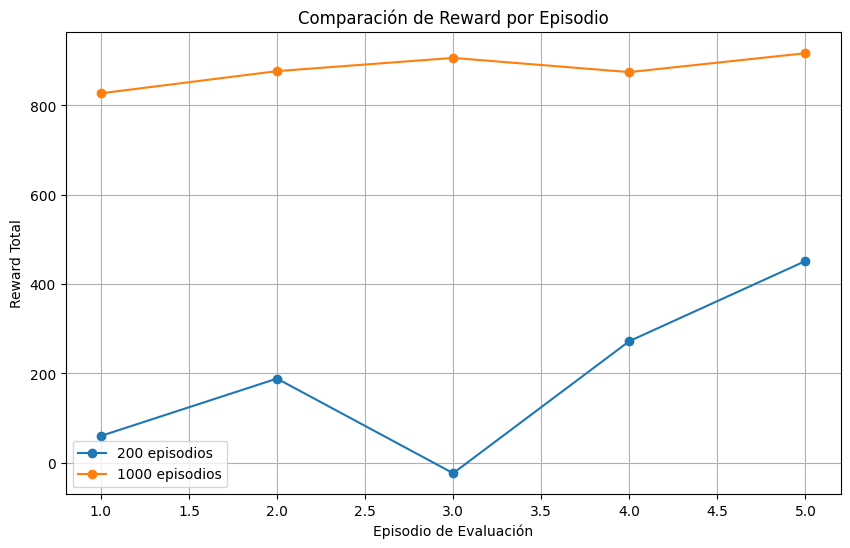

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for nombre, df in metricas.items():
    plt.plot(df["episodio"], df["reward_total"], marker="o", label=nombre)

plt.title("Comparación de Reward por Episodio")
plt.xlabel("Episodio de Evaluación")
plt.ylabel("Reward Total")
plt.grid(True)
plt.legend()
plt.show()



### Interpretación del gráfico

En el gráfico se compara el *reward total* obtenido por dos agentes DQN entrenados con distinta cantidad de episodios: uno con **200 episodios** y otro con **1000 episodios**. Ambos modelos se evalúan en **5 episodios** de prueba sin exploración (ε = 0), es decir, usando solo la política aprendida.

Se observa que el agente entrenado con **1000 episodios** obtiene recompensas altas y bastante estables en los episodios de evaluación. En promedio logra alrededor de **880.49** puntos y su variación es baja (desviación estándar **~34.96**).

En contraste, el agente entrenado con **200 episodios** muestra mucha variación: en algunos episodios logra un reward aceptable y en otros obtiene recompensas bajas (incluso negativas). En promedio logra alrededor de **189.87**, con una variación alta (desviación estándar **~185.51**).

En general, el gráfico muestra que entrenar más episodios mejora el desempeño promedio y también reduce la variación entre episodios, al menos en estas pruebas.

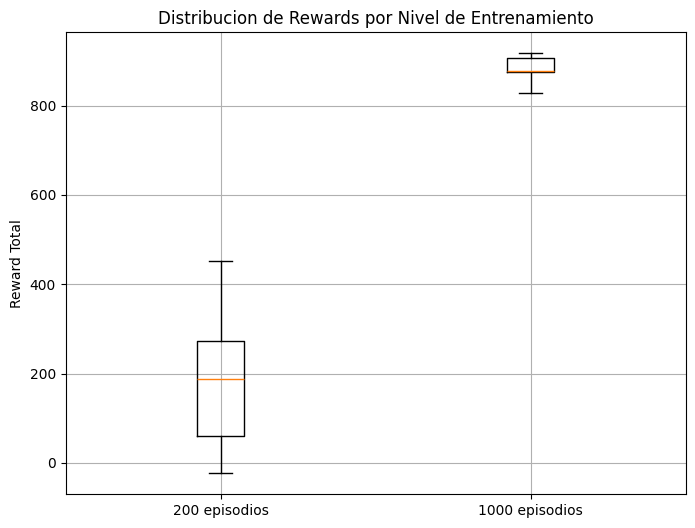

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

data = [
    metricas["200 episodios"]["reward_total"],
    metricas["1000 episodios"]["reward_total"]
]

plt.figure(figsize=(8, 6))
plt.boxplot(
    data,
    tick_labels=["200 episodios", "1000 episodios"]
)
plt.title("Distribucion de Rewards por Nivel de Entrenamiento")
plt.ylabel("Reward Total")
plt.grid(True)
plt.show()



## Lección aprendida

A partir de los experimentos y del análisis de resultados, se puede notar que en Aprendizaje por Refuerzo no basta con que el agente obtenga un buen *reward* en uno o dos episodios. También importa que el comportamiento sea **estable** en varios episodios.

En el modelo entrenado con **200 episodios**, a veces logra recompensas aceptables, pero su desempeño cambia mucho entre episodios. Esto sugiere que el agente todavía está aprendiendo y que pequeñas diferencias al inicio del episodio pueden llevar a resultados muy distintos.

En cambio, el modelo entrenado con **1000 episodios** no solo logra recompensas más altas, sino que también se comporta de manera más pareja entre episodios. Esto sugiere que con más interacción con el entorno el agente mejora su forma de conducir, comete menos errores y se adapta mejor a diferentes pistas.

In [8]:
resumen = []

for nombre, df in metricas.items():
    resumen.append({
        "Modelo": nombre,
        "Reward promedio": df["reward_total"].mean(),
        "Reward máximo": df["reward_total"].max(),
        "Reward mínimo": df["reward_total"].min(),
        "Desviación estándar": df["reward_total"].std()
    })

resumen_df = pd.DataFrame(resumen)
resumen_df


,Modelo,Reward promedio,Reward máximo,Reward mínimo,Desviación estándar
0,200 episodios,189.873087,451.724138,-23.333333,185.506265
1,1000 episodios,880.485009,917.000000,827.272727,34.955284


### CONCLUSIONES

La tabla anterior resume el desempeño del agente DQN evaluado con distintos niveles de entrenamiento.

En el modelo entrenado con **200 episodios**, el reward promedio es de **~189.87** y la **desviación estándar es alta** (**~185.51**), lo que indica un comportamiento poco estable. Esto también se refleja en el reward mínimo negativo (**~ -23.33**), señal de que en algunos episodios el agente aún comete errores y no logra sostener una conducción regular.

Por otro lado, el modelo entrenado con **1000 episodios** presenta un reward promedio mucho mayor (**~880.49**) y una **desviación estándar mucho menor** (**~34.96**). Además, el reward mínimo es alto (**~827.27**), lo que indica que incluso en su peor episodio evaluado mantiene un buen desempeño.

En conjunto, estos resultados muestran que entrenar más episodios ayuda al agente a aprender una política de conducción más estable y con mejor desempeño en CarRacing-v3.

#### TODO / Trabajo futuro (mejoras posibles para el final)

- Comparar **DQN vs Double DQN** para reducir la sobreestimación de valores Q.
- Probar **Dueling DQN** (separar *Value* y *Advantage*) para mejorar el aprendizaje en estados similares.
- Implementar **Prioritized Experience Replay (PER)** para muestrear transiciones más informativas con mayor probabilidad.
- Probar **n-step returns** (multi-step) para acelerar el aprendizaje de recompensas a más largo plazo.
- Mejorar exploración: ajustar el decaimiento de ε (más gradual) o probar **Noisy Networks** (exploración por ruido en parámetros).
- Explorar enfoques **Actor-Critic**: **A2C/A3C** (y, si se busca estabilidad, **PPO**) para comparar con DQN en este entorno.
- Estabilización del entrenamiento: **Huber loss**, **gradient clipping**, y/o actualización suave del target (Polyak).
- Evaluación más robusta: más episodios de prueba, varias semillas y promedios/intervalos de confianza.

#### Referencias (base teórica)

* Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., Graves, A., Riedmiller, M., Fidjeland, A. K., Ostrovski, G., Petersen, S., Beattie, C., Sadik, A., Antonoglou, I., King, H., Kumaran, D., Wierstra, D., Legg, S., & Hassabis, D. (2015). Human-level control through deep reinforcement learning. *Nature, 518*, 529–533. [https://doi.org/10.1038/nature14236](https://doi.org/10.1038/nature14236) ([Nature][1])

* Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. (2013). *Playing Atari with Deep Reinforcement Learning* (arXiv:1312.5602). *arXiv*. https://arxiv.org/abs/1312.5602

* van Hasselt, H., Guez, A., & Silver, D. (2016). Deep reinforcement learning with double Q-learning. In *Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence (AAAI-16)* (pp. 2094–2100). AAAI Press. [https://doi.org/10.1609/aaai.v30i1.10295](https://doi.org/10.1609/aaai.v30i1.10295) ([DBLP][2])

* Wang, Z., Schaul, T., Hessel, M., van Hasselt, H., Lanctot, M., & de Freitas, N. (2016). Dueling network architectures for deep reinforcement learning. In M. F. Balcan & K. Q. Weinberger (Eds.), *Proceedings of the 33rd International Conference on Machine Learning* (Vol. 48, pp. 1995–2003). PMLR. [https://proceedings.mlr.press/v48/wangf16.html](https://proceedings.mlr.press/v48/wangf16.html) ([Proceedings of Machine Learning Research][3])

* Schaul, T., Quan, J., Antonoglou, I., & Silver, D. (2016). Prioritized experience replay. In *International Conference on Learning Representations (ICLR 2016)*. [https://arxiv.org/abs/1511.05952](https://arxiv.org/abs/1511.05952) ([arXiv][4])

* Mnih, V., Puigdomenech Badia, A., Mirza, M., Graves, A., Lillicrap, T., Harley, T., Silver, D., & Kavukcuoglu, K. (2016). Asynchronous methods for deep reinforcement learning. In M. F. Balcan & K. Q. Weinberger (Eds.), *Proceedings of the 33rd International Conference on Machine Learning* (Vol. 48, pp. 1928–1937). PMLR. [https://proceedings.mlr.press/v48/mniha16.html](https://proceedings.mlr.press/v48/mniha16.html) ([Proceedings of Machine Learning Research][5])

* Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017). Proximal policy optimization algorithms (arXiv:1707.06347). *arXiv*. [https://arxiv.org/abs/1707.06347](https://arxiv.org/abs/1707.06347) ([arXiv][6])

* Farama Foundation. (n.d.). *Car Racing (CarRacing-v3)*. Gymnasium Documentation. Recuperado el 13 de diciembre de 2025, de https://gymnasium.farama.org/environments/box2d/car_racing/

* Paszke, A., & Towers, M. (2025, 16 de junio). *Reinforcement Learning (DQN) Tutorial*. PyTorch Tutorials. https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

##### Software y librerías

* Bradski, G. (2000). The OpenCV Library. *Dr. Dobb’s Journal of Software Tools*. 

* Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., Gérard-Marchant, P., Sheppard, K., Reddy, T., Weckesser, W., Abbasi, H., Gohlke, C., & Oliphant, T. E. (2020). Array programming with NumPy. *Nature, 585*(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2

* Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in Science & Engineering, 9*(3), 90–95. https://doi.org/10.1109/MCSE.2007.55

* McKinney, W. (2010). Data structures for statistical computing in Python. In *Proceedings of the 9th Python in Science Conference* (pp. 56–61). https://conference.scipy.org/proceedings/scipy2010/mckinney.html

* Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., Killeen, T., Lin, Z., Gimelshein, N., Antiga, L., Desmaison, A., Kopf, A., Yang, E., DeVito, Z., Raison, M., Tejani, A., Chilamkurthy, S., Steiner, B., Fang, L., Bai, J., & Chintala, S. (2019). PyTorch: An imperative style, high-performance deep learning library. In H. Wallach, H. Larochelle, A. Beygelzimer, F. d’Alché-Buc, E. Fox, & R. Garnett (Eds.), *Advances in Neural Information Processing Systems 32*. https://arxiv.org/abs/1912.01703

#### Transparencia (uso de herramientas)

Este trabajo fue desarrollado por el equipo (Grupo 4 del curso de Aprendizaje por Reforzamiento). Se utilizaron herramientas de apoyo (incluyendo asistentes de IA) para mejorar redacción/documentación y revisar consistencia del reporte, pero el diseño, implementación, ejecución de experimentos y análisis de resultados corresponden al equipo. 

**Hasta aquí llega el avance del parcial. Quedamos atentos a las recomendaciones para mejorar el experimento y el análisis.**